In [7]:
from pathlib import Path
import torch
import torchaudio

from speechbrain.pretrained import EncoderClassifier
from speechbrain.lobes.models.ECAPA_TDNN import ECAPA_TDNN

ROOT = Path("..").resolve()  # if notebook is in ./notebooks

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Running on CPU")

print("Loading SpeechBrain ECAPA-TDNN...")

model = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir=str(ROOT / "ecapa_pretrained"),
    run_opts={"device": str(device)},
)

backbone: ECAPA_TDNN = model.mods["embedding_model"]
backbone.to(device)
backbone.eval()

print("ECAPA loaded successfully.")


Running on GPU: NVIDIA GeForce RTX 3090
Loading SpeechBrain ECAPA-TDNN...
ECAPA loaded successfully.


# ECAPA-TDNN + TCAV on Mel Concepts

This notebook:
- Loads a pretrained SpeechBrain ECAPA-TDNN model
- Uses synthetic mel-based concepts (rising / dropping / constant lines, etc.)
- Computes CAVs on 3 internal SE-Res2 blocks
- Computes TCAV scores:
  - Globally (all 90 recordings)
  - Per speaker (eden / idan / yoav)
- Saves results to `tcav_results.csv`
- Draws heatmaps for:
  - Concept × Layer (global)
  - Concept × Layer per speaker


In [8]:
from pathlib import Path
import sys
import numpy as np
import torch

from tqdm import tqdm
from sklearn.linear_model import SGDClassifier

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Project root = parent of this notebook folder
ROOT = Path("..").resolve()

# Add concept folder to Python path
sys.path.append(str(ROOT / "concept"))

CONCEPT_ROOT = ROOT / "concept" / "positive concepts dataset"
DATA_DIR = ROOT / "data" / "wavs"

from Preprocess import audio_to_mel_spectrogram
from PreprocessParams import FREQUENCY_BIN_COUNT

np.random.seed(42)
torch.manual_seed(42)


if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Running on CPU")



Running on GPU: NVIDIA GeForce RTX 3090


In [9]:
backbone: ECAPA_TDNN = model.mods["embedding_model"]
backbone.to(device)
backbone.eval()
print(backbone)
print("Backbone blocks:", backbone.blocks)

TARGET_LAYERS = {
    "seres2_1": backbone.blocks[1],
    "seres2_2": backbone.blocks[2],
    "seres2_3": backbone.blocks[3],
}


ECAPA_TDNN(
  (blocks): ModuleList(
    (0): TDNNBlock(
      (conv): Conv1d(
        (conv): Conv1d(80, 1024, kernel_size=(5,), stride=(1,))
      )
      (activation): ReLU()
      (norm): BatchNorm1d(
        (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (dropout): Dropout1d(p=0.0, inplace=False)
    )
    (1): SERes2NetBlock(
      (tdnn1): TDNNBlock(
        (conv): Conv1d(
          (conv): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
        )
        (activation): ReLU()
        (norm): BatchNorm1d(
          (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (dropout): Dropout1d(p=0.0, inplace=False)
      )
      (res2net_block): Res2NetBlock(
        (blocks): ModuleList(
          (0-6): 7 x TDNNBlock(
            (conv): Conv1d(
              (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,), dilation=(2,))
            )
            (activation): ReL

In [10]:
def mel_to_input(mel: np.ndarray) -> torch.Tensor:
    """
    mel: (F, T) = (64, T) → Tensor (1, T, 64) on device
    """
    mel = torch.tensor(mel, dtype=torch.float32)  # (F, T)
    return mel.T.unsqueeze(0).to(device)  # (1, T, F)


def get_activation_from_layer(mel: np.ndarray, layer: torch.nn.Module) -> np.ndarray:
    """
    Run backbone up to the given layer and return activation as a NumPy array.
    """
    activations: dict[str, torch.Tensor] = {}

    def hook_fn(_, __, out):
        # store as tensor on CPU
        activations["A"] = out.detach().cpu().clone()

    handle = layer.register_forward_hook(hook_fn)
    x = mel_to_input(mel)
    with torch.no_grad():
        _ = backbone(x)
    handle.remove()

    A_t = activations["A"]            # torch.Tensor on CPU
    A = np.array(A_t.tolist(), dtype=np.float32)
    return A  # shape (1, C, T') or (1, T', C)



def activation_to_vec(A: np.ndarray) -> np.ndarray:
    """
    Convert a layer activation to a 1D vector by averaging over time.
    """
    A = A.squeeze(0)  # remove batch → (C, T') or (T', C)
    if A.ndim != 2:
        raise RuntimeError(f"Expected 2D activation, got shape {A.shape}")

    # If first dim is channels
    if A.shape[0] < A.shape[1]:
        return A.mean(axis=1)  # (C,)
    else:
        return A.mean(axis=0)  # (C,)


In [11]:
# All concept subfolders in positive concepts dataset
concept_dirs = sorted([d for d in CONCEPT_ROOT.iterdir() if d.is_dir()])

print("Found concept dirs:")
for d in concept_dirs:
    print(" -", d.name)

if len(concept_dirs) < 2:
    raise RuntimeError("Need at least 2 concept folders for TCAV (pos vs neg).")


Found concept dirs:
 - long_constant_thick
 - long_dropping_flat_thick
 - long_dropping_steep_thick
 - long_dropping_steep_thin
 - long_rising_flat_thick
 - long_rising_steep_thick
 - long_rising_steep_thin
 - short_constant_thick
 - short_dropping_steep_thick
 - short_dropping_steep_thin
 - short_rising_steep_thick
 - short_rising_steep_thin


In [12]:
from collections import defaultdict

def load_eval_mels_and_group():
    wavs = sorted(DATA_DIR.glob("*.wav"))
    if len(wavs) == 0:
        raise RuntimeError(f"No wav files found in {DATA_DIR}")

    wav_files = wavs
    eval_mels = []

    for w in wav_files:
        mel = audio_to_mel_spectrogram(w)
        if mel.shape[0] != FREQUENCY_BIN_COUNT:
            raise RuntimeError(f"Mel dimension mismatch in {w}, got {mel.shape}")
        eval_mels.append(mel)

    # Group by speaker prefix: eden / idan / yoav
    speaker_mels = defaultdict(list)
    speaker_wavs = defaultdict(list)

    for w, mel in zip(wav_files, eval_mels):
        name = w.name.lower()
        if name.startswith("eden"):
            speaker = "eden"
        elif name.startswith("idan"):
            speaker = "idan"
        elif name.startswith("yoav"):
            speaker = "yoav"
        else:
            speaker = "other"
        speaker_mels[speaker].append(mel)
        speaker_wavs[speaker].append(w.name)

    return wav_files, eval_mels, speaker_mels, speaker_wavs

wav_files, eval_mels, speaker_mels, speaker_wavs = load_eval_mels_and_group()

print("Total eval mels:", len(eval_mels))
for spk, files in speaker_wavs.items():
    print(f"Speaker {spk}: {len(files)} files")


Total eval mels: 90
Speaker eden: 30 files
Speaker idan: 30 files
Speaker yoav: 30 files


In [13]:
def build_cav_for_concept_and_layer(layer_name: str,
                                    concept_dir: Path,
                                    all_concept_dirs: list[Path]) -> np.ndarray:
    """
    Build a CAV vector for:
      - positive examples from concept_dir
      - negative examples from all other concept dirs (sampled)
    """
    layer = TARGET_LAYERS[layer_name]

    pos_paths = sorted(concept_dir.glob("*.npy"))
    if len(pos_paths) == 0:
        raise RuntimeError(f"No .npy files in {concept_dir}")

    # Collect all negative npy files from other concept dirs
    neg_paths_all = []
    for d in all_concept_dirs:
        if d == concept_dir:
            continue
        neg_paths_all.extend(sorted(d.glob("*.npy")))

    if len(neg_paths_all) == 0:
        raise RuntimeError("No negative concept samples found.")

    # Sample negatives to have roughly balanced classes
    n_pos = len(pos_paths)
    n_neg = min(len(neg_paths_all), n_pos * 2)  # up to 2x negatives
    neg_indices = np.random.choice(len(neg_paths_all), size=n_neg, replace=False)
    neg_paths = [neg_paths_all[i] for i in neg_indices]

    X = []
    Y = []

    # Positive = concept
    for p in pos_paths:
        mel = np.load(p)
        A = get_activation_from_layer(mel, layer)
        X.append(activation_to_vec(A))
        Y.append(1)

    # Negative = all other concepts
    for p in neg_paths:
        mel = np.load(p)
        A = get_activation_from_layer(mel, layer)
        X.append(activation_to_vec(A))
        Y.append(0)

    X = np.vstack(X)
    Y = np.array(Y)

    clf = SGDClassifier(loss="hinge", alpha=1e-4, max_iter=2000)
    clf.fit(X, Y)

    cav = clf.coef_.reshape(-1)
    cav /= (np.linalg.norm(cav) + 1e-8)
    return cav


In [14]:
def tcav_score_all(layer_name: str, cav: np.ndarray) -> float:
    """
    Compute TCAV score on all eval_mels:
    fraction of examples where directional derivative > 0.
    """
    layer = TARGET_LAYERS[layer_name]
    positives = 0
    total = 0

    for mel in eval_mels:
        x = mel_to_input(mel)
        x.requires_grad_(True)

        activations: dict[str, torch.Tensor] = {}

        def hook_fn(_, __, out):
            out.retain_grad()
            activations["A"] = out

        handle = layer.register_forward_hook(hook_fn)
        out = backbone(x)
        handle.remove()

        # simple scalar "task" = norm of embedding
        loss = out.norm()
        loss.backward()

        grad_t = activations["A"].grad.detach().cpu()
        grad = np.array(grad_t.tolist(), dtype=np.float32).squeeze(0)

        # time-mean
        if grad.shape[0] < grad.shape[1]:
            g_vec = grad.mean(axis=1)
        else:
            g_vec = grad.mean(axis=0)

        directional_derivative = np.dot(g_vec, cav)
        positives += (directional_derivative > 0)
        total += 1

        # clear gradients for safety
        backbone.zero_grad()
        model.zero_grad()

    return positives / total if total > 0 else 0.0


In [15]:
def tcav_score_for_speaker(layer_name: str,
                           cav: np.ndarray,
                           speaker: str) -> float:
    """
    TCAV score restricted to a given speaker's mel list.
    """
    if speaker not in speaker_mels:
        raise RuntimeError(f"No mels for speaker '{speaker}'")

    layer = TARGET_LAYERS[layer_name]
    mels = speaker_mels[speaker]

    positives = 0
    total = 0

    for mel in mels:
        x = mel_to_input(mel)
        x.requires_grad_(True)

        activations: dict[str, torch.Tensor] = {}

        def hook_fn(_, __, out):
            out.retain_grad()
            activations["A"] = out

        handle = layer.register_forward_hook(hook_fn)
        out = backbone(x)
        handle.remove()

        loss = out.norm()
        loss.backward()

        grad_t = activations["A"].grad.detach().cpu().clone()
        grad = np.array(grad_t.tolist(), dtype=np.float32).squeeze(0)

        if grad.shape[0] < grad.shape[1]:
            g_vec = grad.mean(axis=1)
        else:
            g_vec = grad.mean(axis=0)

        directional_derivative = np.dot(g_vec, cav)
        positives += (directional_derivative > 0)
        total += 1

        backbone.zero_grad()
        model.zero_grad()

    return positives / total if total > 0 else 0.0


In [16]:
results_global = []   # list of dicts: {concept, layer, tcav}
cavs = {}            # (concept_name, layer_name) -> cav vector

for cdir in tqdm(concept_dirs, desc="Concepts"):
    cname = cdir.name
    print(f"\n=== Concept: {cname} ===")

    for layer_name in TARGET_LAYERS.keys():
        print(f"  Building CAV for layer {layer_name} ...")
        cav = build_cav_for_concept_and_layer(layer_name, cdir, concept_dirs)
        cavs[(cname, layer_name)] = cav

        print("  Computing global TCAV...")
        score = tcav_score_all(layer_name, cav)
        results_global.append({
            "Concept": cname,
            "Layer": layer_name,
            "Speaker": "all",
            "TCAV": score,
        })
        print(f"    TCAV(all) = {score:.3f}")


Concepts:   0%|          | 0/12 [00:00<?, ?it/s]


=== Concept: long_constant_thick ===
  Building CAV for layer seres2_1 ...
  Computing global TCAV...
    TCAV(all) = 0.622
  Building CAV for layer seres2_2 ...
  Computing global TCAV...
    TCAV(all) = 0.500
  Building CAV for layer seres2_3 ...
  Computing global TCAV...


Concepts:   8%|▊         | 1/12 [00:36<06:37, 36.16s/it]

    TCAV(all) = 0.967

=== Concept: long_dropping_flat_thick ===
  Building CAV for layer seres2_1 ...
  Computing global TCAV...
    TCAV(all) = 0.856
  Building CAV for layer seres2_2 ...
  Computing global TCAV...
    TCAV(all) = 0.633
  Building CAV for layer seres2_3 ...
  Computing global TCAV...


Concepts:  17%|█▋        | 2/12 [01:11<05:54, 35.49s/it]

    TCAV(all) = 0.811

=== Concept: long_dropping_steep_thick ===
  Building CAV for layer seres2_1 ...
  Computing global TCAV...
    TCAV(all) = 0.444
  Building CAV for layer seres2_2 ...
  Computing global TCAV...
    TCAV(all) = 0.400
  Building CAV for layer seres2_3 ...
  Computing global TCAV...


Concepts:  25%|██▌       | 3/12 [01:46<05:17, 35.22s/it]

    TCAV(all) = 0.144

=== Concept: long_dropping_steep_thin ===
  Building CAV for layer seres2_1 ...
  Computing global TCAV...
    TCAV(all) = 0.078
  Building CAV for layer seres2_2 ...
  Computing global TCAV...
    TCAV(all) = 0.356
  Building CAV for layer seres2_3 ...
  Computing global TCAV...


Concepts:  33%|███▎      | 4/12 [02:20<04:38, 34.85s/it]

    TCAV(all) = 0.833

=== Concept: long_rising_flat_thick ===
  Building CAV for layer seres2_1 ...
  Computing global TCAV...
    TCAV(all) = 0.922
  Building CAV for layer seres2_2 ...
  Computing global TCAV...
    TCAV(all) = 0.344
  Building CAV for layer seres2_3 ...
  Computing global TCAV...


Concepts:  42%|████▏     | 5/12 [02:55<04:05, 35.08s/it]

    TCAV(all) = 0.756

=== Concept: long_rising_steep_thick ===
  Building CAV for layer seres2_1 ...
  Computing global TCAV...
    TCAV(all) = 0.033
  Building CAV for layer seres2_2 ...
  Computing global TCAV...
    TCAV(all) = 0.478
  Building CAV for layer seres2_3 ...
  Computing global TCAV...


Concepts:  50%|█████     | 6/12 [03:31<03:32, 35.40s/it]

    TCAV(all) = 0.856

=== Concept: long_rising_steep_thin ===
  Building CAV for layer seres2_1 ...
  Computing global TCAV...
    TCAV(all) = 0.944
  Building CAV for layer seres2_2 ...
  Computing global TCAV...
    TCAV(all) = 0.544
  Building CAV for layer seres2_3 ...
  Computing global TCAV...


Concepts:  58%|█████▊    | 7/12 [04:05<02:54, 34.81s/it]

    TCAV(all) = 0.667

=== Concept: short_constant_thick ===
  Building CAV for layer seres2_1 ...
  Computing global TCAV...
    TCAV(all) = 0.056
  Building CAV for layer seres2_2 ...
  Computing global TCAV...
    TCAV(all) = 0.322
  Building CAV for layer seres2_3 ...
  Computing global TCAV...


Concepts:  67%|██████▋   | 8/12 [04:37<02:16, 34.04s/it]

    TCAV(all) = 0.911

=== Concept: short_dropping_steep_thick ===
  Building CAV for layer seres2_1 ...
  Computing global TCAV...
    TCAV(all) = 0.800
  Building CAV for layer seres2_2 ...
  Computing global TCAV...
    TCAV(all) = 0.589
  Building CAV for layer seres2_3 ...
  Computing global TCAV...


Concepts:  75%|███████▌  | 9/12 [05:11<01:42, 34.02s/it]

    TCAV(all) = 0.078

=== Concept: short_dropping_steep_thin ===
  Building CAV for layer seres2_1 ...
  Computing global TCAV...
    TCAV(all) = 0.956
  Building CAV for layer seres2_2 ...
  Computing global TCAV...
    TCAV(all) = 0.444
  Building CAV for layer seres2_3 ...
  Computing global TCAV...


Concepts:  83%|████████▎ | 10/12 [05:44<01:07, 33.70s/it]

    TCAV(all) = 0.133

=== Concept: short_rising_steep_thick ===
  Building CAV for layer seres2_1 ...
  Computing global TCAV...
    TCAV(all) = 0.044
  Building CAV for layer seres2_2 ...
  Computing global TCAV...
    TCAV(all) = 0.678
  Building CAV for layer seres2_3 ...
  Computing global TCAV...


Concepts:  92%|█████████▏| 11/12 [06:18<00:33, 33.81s/it]

    TCAV(all) = 0.600

=== Concept: short_rising_steep_thin ===
  Building CAV for layer seres2_1 ...
  Computing global TCAV...
    TCAV(all) = 0.044
  Building CAV for layer seres2_2 ...
  Computing global TCAV...
    TCAV(all) = 0.500
  Building CAV for layer seres2_3 ...
  Computing global TCAV...


Concepts: 100%|██████████| 12/12 [06:51<00:00, 34.33s/it]

    TCAV(all) = 0.100


In [17]:
results_speaker = []

for (cname, layer_name), cav in cavs.items():
    for speaker in ["eden", "idan", "yoav"]:
        if speaker not in speaker_mels or len(speaker_mels[speaker]) == 0:
            continue

        s_score = tcav_score_for_speaker(layer_name, cav, speaker)
        results_speaker.append({
            "Concept": cname,
            "Layer": layer_name,
            "Speaker": speaker,
            "TCAV": s_score,
        })
        print(f"{cname} | {layer_name} | {speaker} → {s_score:.3f}")


long_constant_thick | seres2_1 | eden → 0.367
long_constant_thick | seres2_1 | idan → 0.933
long_constant_thick | seres2_1 | yoav → 0.567
long_constant_thick | seres2_2 | eden → 0.367
long_constant_thick | seres2_2 | idan → 0.767
long_constant_thick | seres2_2 | yoav → 0.367
long_constant_thick | seres2_3 | eden → 1.000
long_constant_thick | seres2_3 | idan → 0.933
long_constant_thick | seres2_3 | yoav → 0.967
long_dropping_flat_thick | seres2_1 | eden → 0.933
long_dropping_flat_thick | seres2_1 | idan → 0.933
long_dropping_flat_thick | seres2_1 | yoav → 0.700
long_dropping_flat_thick | seres2_2 | eden → 0.533
long_dropping_flat_thick | seres2_2 | idan → 0.833
long_dropping_flat_thick | seres2_2 | yoav → 0.533
long_dropping_flat_thick | seres2_3 | eden → 0.800
long_dropping_flat_thick | seres2_3 | idan → 0.933
long_dropping_flat_thick | seres2_3 | yoav → 0.700
long_dropping_steep_thick | seres2_1 | eden → 0.533
long_dropping_steep_thick | seres2_1 | idan → 0.433
long_dropping_steep_thi

In [18]:
import pandas as pd

# ===========================================
# EXTRACT TCAV DIRECTIONAL VALUES PER WAV (LAYER 3)
# ===========================================

selected_layer = "seres2_3"   # 3rd layer
layer = TARGET_LAYERS[selected_layer]

# All concept names that have a CAV for this layer
concept_names = sorted({
    cname
    for (cname, layer_name) in cavs.keys()
    if layer_name == selected_layer
})

# Build column names: "[concept_name] (val)"
concept_cols = [f"{cname}" for cname in concept_names]

rows = []

for wav_path, mel in zip(wav_files, eval_mels):
    x = mel_to_input(mel)
    x.requires_grad_(True)

    activations: dict[str, torch.Tensor] = {}

    def hook_fn(_, __, out):
        out.retain_grad()
        activations["A"] = out

    handle = layer.register_forward_hook(hook_fn)
    out = backbone(x)
    handle.remove()

    loss = out.norm()
    loss.backward()

    # IMPORTANT: no .numpy() directly on tensor
    grad_t = activations["A"].grad.detach().cpu()
    grad = np.array(grad_t.tolist(), dtype=np.float32).squeeze(0)

    if grad.shape[0] < grad.shape[1]:
        g_vec = grad.mean(axis=1)
    else:
        g_vec = grad.mean(axis=0)

    row = {"wav_name": wav_path.name}

    # fill each concept column with its directional derivative
    for cname in concept_names:
        cav = cavs[(cname, selected_layer)]
        dd = float(np.dot(g_vec, cav))   # directional derivative
        col_name = f"{cname}"
        row[col_name] = dd

    rows.append(row)

    backbone.zero_grad()
    model.zero_grad()

# Create DataFrame with desired column order
df_tcav_wavs = pd.DataFrame(rows, columns=["wav_name"] + concept_cols)

csv_path = "tcav_per_wav_layer3.csv"
df_tcav_wavs.to_csv(csv_path, index=False)

print(f"Saved CSV → {csv_path}")
df_tcav_wavs.head()


Saved CSV → tcav_per_wav_layer3.csv


,wav_name,long_constant_thick,long_dropping_flat_thick,long_dropping_steep_thick,long_dropping_steep_thin,long_rising_flat_thick,long_rising_steep_thick,long_rising_steep_thin,short_constant_thick,short_dropping_steep_thick,short_dropping_steep_thin,short_rising_steep_thick,short_rising_steep_thin
0,eden_001.wav,0.002250,0.000923,-0.002655,0.002089,0.001381,0.002002,0.000348,0.001594,-0.002127,-0.003146,-1.591222e-05,-0.002849
1,eden_002.wav,0.002071,0.001508,-0.003197,0.002555,0.001049,0.002591,0.000250,0.001963,-0.002172,-0.003504,3.089477e-04,-0.003445
2,eden_003.wav,0.002516,0.000894,-0.002400,0.002422,0.001592,0.001305,0.000320,0.001700,-0.001963,-0.003356,4.118087e-04,-0.003030
3,eden_004.wav,0.002272,0.000010,-0.001321,0.001128,0.000148,0.000689,-0.000130,0.001504,-0.001745,-0.001769,-3.746104e-07,-0.001609
4,eden_005.wav,0.000220,0.001180,-0.001870,0.001313,0.000036,0.001654,0.000290,0.001757,-0.000877,-0.001448,-3.168442e-04,-0.001534


In [19]:
df_global = pd.DataFrame(results_global)
df_speaker = pd.DataFrame(results_speaker)

df_all = pd.concat([df_global, df_speaker], ignore_index=True)

csv_path = ROOT / "tcav_results.csv"
df_all.to_csv(csv_path, index=False)

print("Saved all TCAV results to:", csv_path)
df_all.head()


Saved all TCAV results to: /home/SpeakerRec/ecapa_tcav/tcav_results.csv


,Concept,Layer,Speaker,TCAV
0,long_constant_thick,seres2_1,all,0.622222
1,long_constant_thick,seres2_2,all,0.500000
2,long_constant_thick,seres2_3,all,0.966667
3,long_dropping_flat_thick,seres2_1,all,0.855556
4,long_dropping_flat_thick,seres2_2,all,0.633333


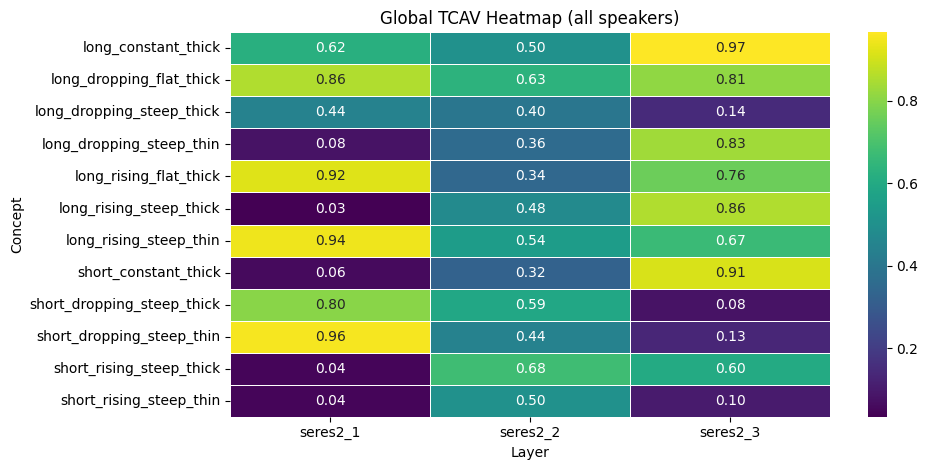

In [20]:
# Filter only global rows (Speaker == "all")
df_global_only = df_all[df_all["Speaker"] == "all"]

heatmap_df = df_global_only.pivot(
    index="Concept",
    columns="Layer",
    values="TCAV"
).sort_index()

plt.figure(figsize=(10, max(4, 0.4 * len(heatmap_df))))
sns.heatmap(
    heatmap_df,
    annot=True,
    cmap="viridis",
    fmt=".2f",
    linewidths=0.5
)
plt.title("Global TCAV Heatmap (all speakers)")
plt.tight_layout()
plt.show()


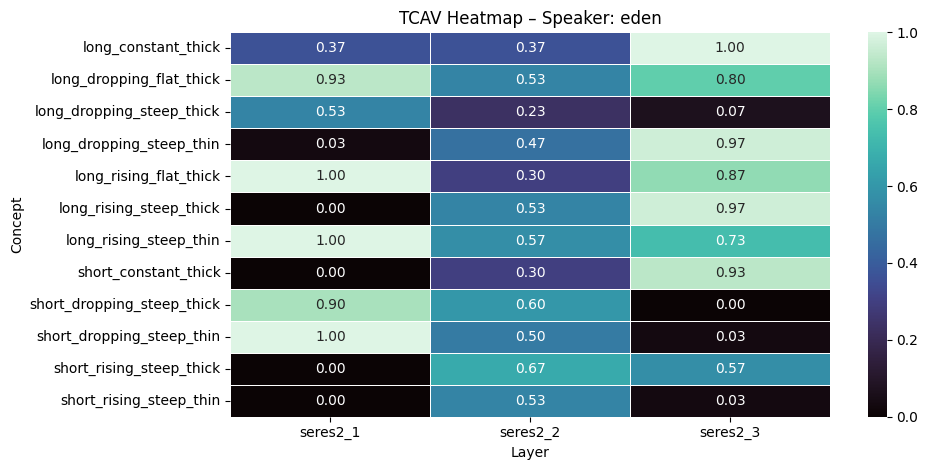

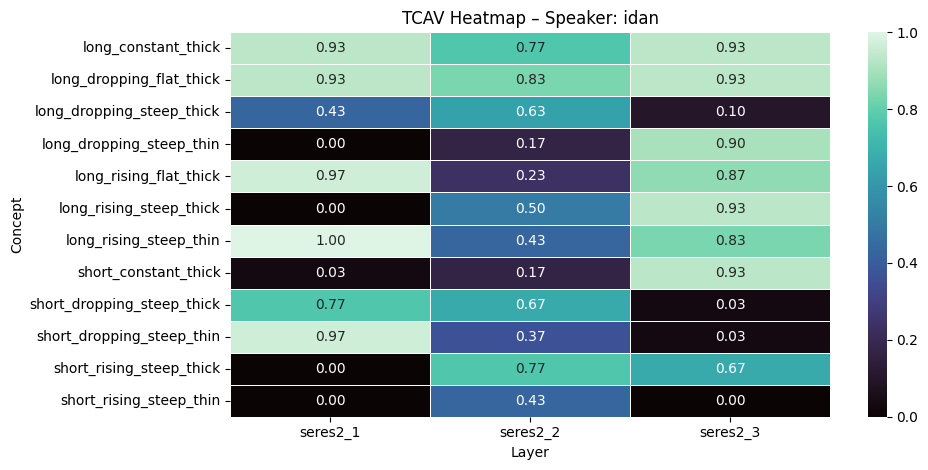

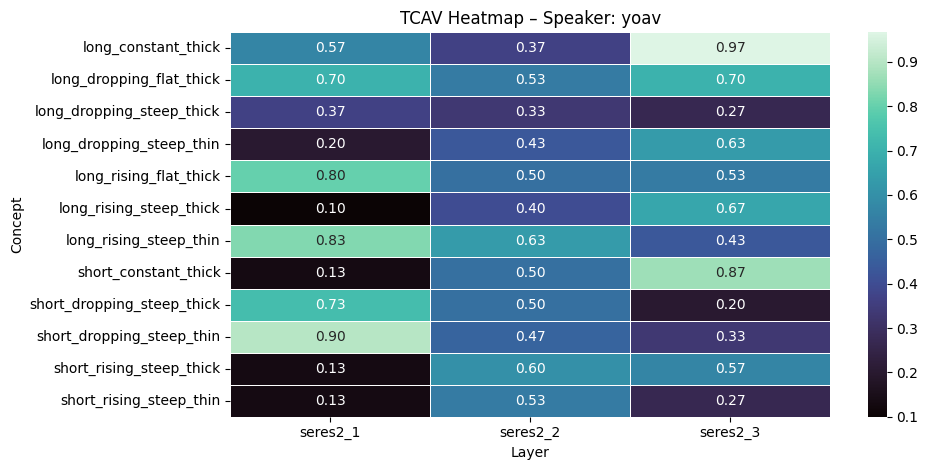

In [21]:
for speaker in ["eden", "idan", "yoav"]:
    df_spk = df_all[df_all["Speaker"] == speaker]
    if df_spk.empty:
        continue

    pivot_df = df_spk.pivot(
        index="Concept",
        columns="Layer",
        values="TCAV"
    ).sort_index()

    plt.figure(figsize=(10, max(4, 0.4 * len(pivot_df))))
    sns.heatmap(
        pivot_df,
        annot=True,
        cmap="mako",
        fmt=".2f",
        linewidths=0.5
    )
    plt.title(f"TCAV Heatmap – Speaker: {speaker}")
    plt.tight_layout()
    plt.show()
